# Proyecto: Descifrando Mensajes Codificados Usando MCMC

Integrantes: Sebastián Flores y Matías Neto

## Procesamiento de la fuente de texto

In [1]:
%pip install pycipher

You should consider upgrading via the '/home/sflores/anaconda3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import re
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pycipher import SimpleSubstitution


In [3]:
# Cargar el texto
with open("gloria_benitoperezgaldos.txt", "r") as f:
    text = f.readlines()

for i in range(len(text)):
    text[i] = text[i].replace('\n', '')

text = ' '.join(text)

In [4]:
# Sólo minúsculas
clean_text = text.casefold()

# Eliminar tildes
tilde_dict = {'á':'a', 'é': 'e', 'í': 'i', 'ó':'o', 'ú':'u', 'ñ': 'n'}
for key, value in tilde_dict.items():
    clean_text = clean_text.replace(key, value)

# Eliminar caracteres especiales
clean_text = re.sub(r"[^a-zA-Z ]", "", clean_text)
clean_text = clean_text.upper()

In [5]:
def process(word, matrix):
    '''
    Almacena la frecuencia de transiciones de una palabra en una matriz
    
    Argumentos:
        word (string): Palabra a procesar
        matrix (pd.DataFrame): Matriz de transición
    
    Retorna:
        matrix (pd.DataFrame): Matriz de transición actualizada con
                               la palabra procesada
    '''
    letters = list(word)
    matrix.loc[' ', letters[0]] = matrix.loc[' ', letters[0]] + 1
    for i in range(len(word)-1):
        matrix.loc[letters[i], letters[i+1]] = matrix.loc[letters[i], letters[i+1]] + 1
    matrix.loc[letters[len(word)-1], ' '] = matrix.loc[letters[len(word)-1], ' '] + 1
    return matrix

In [6]:
# Creación de la matriz
alphabet = sorted(''.join(set(clean_text)))
matrix = pd.DataFrame(data=np.zeros((len(alphabet), len(alphabet))), index=alphabet, columns=alphabet)
words = clean_text.split()

# Se demora unos minutos
for word in words:
    matrix = process(word, matrix)
transition = matrix.apply(lambda x: x/np.sum(x), axis=1)

### Matriz para ataque de trigrama

In [24]:
def trig_process(word, matrix):
    '''
    Almacena la frecuencia de transiciones de una palabra en una matriz
    
    Argumentos:
        word (string): Palabra a procesar
        matrix (pd.DataFrame): Matriz de transición
    
    Retorna:
        matrix (pd.DataFrame): Matriz de transición actualizada con
                               la palabra procesada
    '''
    letters = list(word)
    if len(word) == 1:
        matrix.loc[' ' + letters[0], ' '] = matrix.loc[' ' + letters[0], ' '] + 1
    else:
        matrix.loc[' ' + letters[0], letters[1]] = matrix.loc[' ' + letters[0], letters[1]] + 1
        for i in range(len(word)-2):
            matrix.loc[letters[i] + letters[i+1], letters[i+2]] = matrix.loc[letters[i] + letters[i+1], letters[i+2]] + 1
        matrix.loc[letters[-2] + letters[-1], ' '] = matrix.loc[letters[-2] + letters[-1], ' '] + 1
    return matrix

trig_index = [f + s for f in list(alphabet) for s in list(alphabet[1:])]
trig_columns = alphabet
trig_matrix = pd.DataFrame(data=np.zeros((len(trig_index), len(trig_columns))), index=trig_index, columns=trig_columns)

for word in words:
    trig_matrix = trig_process(word, trig_matrix)
trig_transition = trig_matrix.apply(lambda x: x/np.sum(x), axis=1)

## Definición de funciones auxiliares para la minimización

In [12]:
def plausibility(ciphertext, key, matrix = transition):
    '''
    Función de plausibilidad que tiene el rol de -U para SA
    
    Argumentos:
        ciphertext (string): Texto codificado
        key (string): Clave del mismo largo que el alfabeto a testear
        matrix (pd.DataFrame): Matriz de transición construida antes
    
    Retorna:
        plausibility (float): valor de la plausibilidad para key
    '''
    cipher = SimpleSubstitution(key)
    plaintext = cipher.decipher(ciphertext, keep_punct = True)
    words = plaintext.split()
    matrix = pd.DataFrame(data=np.zeros((len(alphabet), len(alphabet))), index=alphabet, columns=alphabet)
    for word in words:
        matrix = process(word, matrix)
    plausibility = np.sum((1 + matrix.to_numpy()) * np.log(1 + transition.to_numpy()))
    return plausibility

# Ejemplo
plaintext = "MUCHOS ANOS DESPUES FRENTE AL PELOTON DE FUSILAMIENTO " + \
            "EL CORONEL AURELIANO BUENDIA RECORDO AQUELLA TARDE REMOTA " + \
            "EN QUE SU PADRE LO LLEVO A CONOCER EL HIELO"
real_key = "AJPCZWRLFBDKOTYUQGENHXMIVS"
real_cipher = SimpleSubstitution(real_key)
ciphertext = real_cipher.encipher(plaintext, keep_punct = True)
print(f"Texto cifrado: {ciphertext}")
print(f"Plausibilidad: {plausibility(ciphertext, real_key)}")

Texto cifrado: OHPLYE ATYE CZEUHZE WGZTNZ AK UZKYNYT CZ WHEFKAOFZTNY ZK PYGYTZK AHGZKFATY JHZTCFA GZPYGCY AQHZKKA NAGCZ GZOYNA ZT QHZ EH UACGZ KY KKZXY A PYTYPZG ZK LFZKY
Plausibilidad: 47.44776747911044


In [14]:
# Ejemplo para ver que efectivamente la plausibilidad es menor
example_key = ''.join(random.sample(real_key, len(real_key)))
print("Clave ejemplo: " + example_key)
example_cipher = SimpleSubstitution(example_key)
print("Texto descifrado con la clave: "+example_cipher.decipher(ciphertext, keep_punct=True))
print(f"Plausibilidad: {plausibility(ciphertext, example_key)}")

Clave ejemplo: AZLCRSIEFTKGHWXDVJMYPQOBNU
Texto descifrado con la clave: WMUCTH AJTH DBHZMBH NLBJYB AK ZBKTYTJ DB NMHIKAWIBJYT BK UTLTJBK AMLBKIAJT RMBJDIA LBUTLDT AVMBKKA YALDB LBWTYA BJ VMB HM ZADLB KT KKBOT A UTJTUBL BK CIBKT
Plausibilidad: 31.94764944429556


In [9]:
def neighbor(key):
    '''
    Retorna un vecino aleatorio (con distribución uniforme) de la clave
    
    Argumentos:
        key (str): Clave representada por una permutación del alfabeto
    
    Retorna:
        new_key (str): Clave vecina a key
    '''
    indices = random.sample(list(np.arange(len(key))), 2)
    symbol_a, symbol_b = key[indices[0]], key[indices[1]]
    new_key = list(key)
    new_key[indices[0]] = symbol_b
    new_key[indices[1]] = symbol_a
    new_key = ''.join(new_key)
    return new_key

nghbr = neighbor(example_key)
print(f"Clave ejemplo: {example_key}")
print(f"Vecino: {nghbr}")
print(f"Indices intercambiados: {[i for i in range(len(example_key)) if example_key[i] != nghbr[i]]}")

Clave ejemplo: DBUXNVLCHZGAKOPJMTWEISQFRY
Vecino: DBUXNVHCLZGAKOPJMTWEISQFRY
Indices intercambiados: [6, 8]


In [10]:
''.join(sorted(list(real_key)))

'ABCDEFGHIJKLMNOPQRSTUVWXYZ'

## Optimización

In [34]:
def SADecipher(ciphertext: str, Niter: int, beta,
               initial_key = random.sample(alphabet[1:], len(alphabet) - 1),
               print_period = None):
    '''
    Función que implementa Simmulated Annealing 
    para el problema de descifrado
    
    Argumentos:
        ciphertext: Código a descifrar
        Niter: Número de pasos a realizar
        beta (fun): Función que representa el beta del método de SA
        initial_key (str): una clave inicial para el algoritmo
        print_period: Representa el periodo de actualización. 
            Si no es None, se imprime el estado de la cadena
            y la plausibilidad cada print_period pasos
    
    Retorna:
        key: Estado de la cadena luego de Niter pasos
    '''
    
    U = np.random.uniform(0, 1, size = Niter)
    key = initial_key
    incumbent_plaus = plausibility(ciphertext, key)
    scores = np.zeros(Niter)
    if print_period == None:
        for i in range(Niter):
            scores[i] = incumbent_plaus
            new_key = neighbor(key)
            new_plaus = plausibility(ciphertext, new_key)
            if U[i] <= np.exp(beta(i) * (new_plaus - incumbent_plaus)):
                key = new_key
                incumbent_plaus = new_plaus
    else:
        for i in range(Niter):
            scores[i] = incumbent_plaus
            new_key = neighbor(key)
            new_plaus = plausibility(ciphertext, new_key)
            if U[i] <= np.exp(beta(i) * (new_plaus - incumbent_plaus)):
                key = new_key
                incumbent_plaus = new_plaus
            if i % print_period == 0:
                cipher = SimpleSubstitution(key)
                print(f"Paso {i}")
                print(f"Frase actual: {cipher.decipher(ciphertext, keep_punct = True)}")
                print(f"Plausibilidad: {incumbent_plaus}")
    return key, scores

# Test de SADecipher
beta = lambda x: 1     
sample_advance, sample_scores = SADecipher(ciphertext, 10, beta)
print(f"Estado de la cadena luego de 10 pasos con beta = 1: {sample_advance}")
print(f"Indices intercambiados: {[i for i in range(len(example_key)) if 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'[i] != sample_advance[i]]}")

Estado de la cadena luego de 10 pasos con beta = 1: UQFXRAPLWYKBGDHJCMISNTZEVO
Indices intercambiados: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]


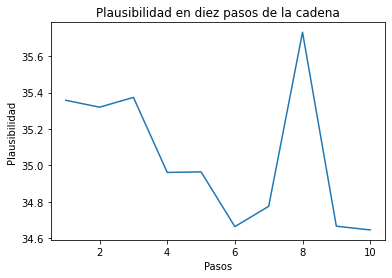

In [12]:
def graph_scores(scores, Niter, title):
    plt.figure()
    plt.plot(np.arange(Niter) + 1, scores)
    plt.title(title)
    plt.xlabel("Pasos")
    plt.ylabel("Plausibilidad")
    plt.show()
    return 

graph_scores(sample_scores, 10, "Plausibilidad en diez pasos de la cadena")

Paso 0
Frase actual: OHPNYE ATYE CZEUHZE WGZTLZ AK UZKYLYT CZ WHEFKAOFZTLY ZK PYGYTZK AHGZKFATY JHZTCFA GZPYGCY AQHZKKA LAGCZ GZOYLA ZT QHZ EH UACGZ KY KKZXY A PYTYPZG ZK NFZKY
Plausibilidad: 35.66793662482362
Paso 1000
Frase actual: FKVWNC QUNC ODCXKDC MHDULD QY XDYNLNU OD MKCIYQFIDULN DY VNHNUDY QKHDYIQUN JKDUOIQ HDVNHON QEKDYYQ LQHOD HDFNLQ DU EKD CK XQOHD YN YYDTN Q VNUNVDH DY WIDYN
Plausibilidad: 33.77144844060628
Paso 2000
Frase actual: QIMHAK LRAK EOKVIOK DCORTO LY VOYATAR EO DIKGYLQGORTA OY MACAROY LICOYGLRA BIOREGL COMACEA LXIOYYL TLCEO COQATL OR XIO KI VLECO YA YYOUA L MARAMOC OY HGOYA
Plausibilidad: 42.46537476734463
Paso 3000
Frase actual: JUHPAN YRAN VENXUEN GDERLE YS XESALAR VE GUNOSYJOERLA ES HADARES YUDESOYRA CUERVOY DEHADVA YQUESSY LYDVE DEJALY ER QUE NU XYVDE SA SSEMA Y HARAHED ES POESA
Plausibilidad: 46.790203613021625
Paso 4000
Frase actual: LUMHAK OSAK TEKPUEK FDESZE OY PEYAZAS TE FUKIYOLIESZA EY MADASEY OUDEYIOSA CUESTIO DEMADTA OQUEYYO ZODTE DELAZO ES QUE KU POTD

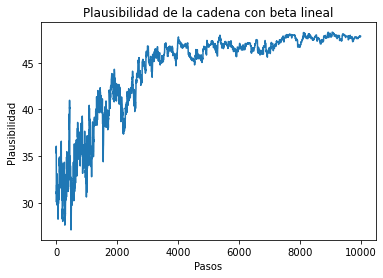

In [62]:
beta = lambda x: 10**(-3) * x
Niter = 10000
beta_lineal, scores_lineal = SADecipher(ciphertext, Niter, beta, print_period = 1000)
print(f"Estado de la cadena luego de 10 pasos con beta lineal: {sample_advance}")
print(f"Indices intercambiados: {[i for i in range(len(example_key)) if 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'[i] != sample_advance[i]]}")
graph_scores(scores_lineal, Niter, "Plausibilidad de la cadena con beta lineal")

Paso 0
Frase actual: OHPLYE ATYE CZEUHZE XGZTNZ AK UZKYNYT CZ XHEFKAOFZTNY ZK PYGYTZK AHGZKFATY JHZTCFA GZPYGCY AQHZKKA NAGCZ GZOYNA ZT QHZ EH UACGZ KY KKZWY A PYTYPZG ZK LFZKY
Plausibilidad: 35.37616047725922
Paso 1000
Frase actual: FOQACN LVCN ZGNIOGN TXGVJG LW IGWCJCV ZG TONBWLFBGVJC GW QCXCVGW LOXGWBLVC UOGVZBL XGQCXZC LHOGWWL JLXZG XGFCJL GV HOG NO ILZXG WC WWGRC L QCVCQGX GW ABGWC
Plausibilidad: 29.886776210638025
Paso 2000
Frase actual: WVAIBS TRBS NYSPVYS OKYRLY TU PYUBLBR NY OVSFUTWFYRLB YU ABKBRYU TVKYUFTRB ZVYRNFT KYABKNB TMVYUUT LTKNY KYWBLT YR MVY SV PTNKY UB UUYGB T ABRBAYK YU IFYUB
Plausibilidad: 32.5529743994809
Paso 3000
Frase actual: PIHBAY XOAY TEYLIEY FVEOZE XS LESAZAO TE FIYDSXPDEOZA ES HAVAOES XIVESDXOA RIEOTDX VEHAVTA XGIESSX ZXVTE VEPAZX EO GIE YI LXTVE SA SSEMA X HAOAHEV ES BDESA
Plausibilidad: 41.343528916747545
Paso 4000
Frase actual: BTDUIE YRIE POECTOE FVORGO YA COAIGIR PO FTESAYBSORGI OA DIVIROA YTVOASYRI MTORPSY VODIVPI YXTOAAY GYVPO VOBIGY OR XTO ET CYPV

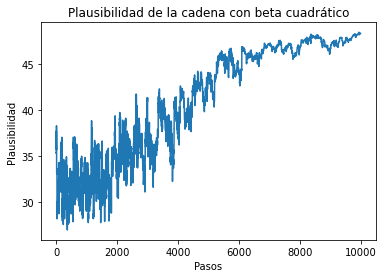

In [76]:
beta = lambda x: 10**(-7) * x ** 2
Niter = 50000
beta_quad, scores_quad = SADecipher(ciphertext, Niter, beta, print_period = 1000)
print(f"Estado de la cadena luego de 10 pasos con beta lineal: {sample_advance}")
print(f"Indices intercambiados: {[i for i in range(len(example_key)) if 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'[i] != sample_advance[i]]}")
graph_scores(scores_quad, Niter, "Plausibilidad de la cadena con beta cuadrático")

### Test con un texto más largo: Entrada de Roberto Bolaño en Wikipedia

In [25]:
def read_text(filepath: str):
    '''
    Lee y limpia un archivo de texto
    '''
    with open("bolano_wikipedia.txt", 'r') as f:
        text = f.readlines()
    for i in range(len(text)):
        text[i] = text[i].replace('\n', '')
    
    text = ' '.join(text)
    # Sólo minúsculas
    clean_text = text.casefold()

    # Eliminar tildes
    tilde_dict = {'á':'a', 'é': 'e', 'í': 'i', 'ó':'o', 'ú':'u', 'ñ': 'n'}
    for key, value in tilde_dict.items():
        clean_text = clean_text.replace(key, value)

    # Eliminar caracteres especiales
    clean_text = re.sub(r"[^a-zA-Z ]", "", clean_text)
    clean_text = clean_text.upper()
    return clean_text

test_text = read_text("bolano_wikipedia.txt")
print(test_text)
print(f"Cantidad de caracteres: {len(test_text)}")

ROBERTO BOLANO AVALOS SANTIAGO DE CHILE VEINTIOCHO DE ABRIL DE MIL NOVECIENTOS CINCUENTA Y TRES  BARCELONA QUINCE DE JULIO DE DOS MIL TRES FUE UN ESCRITOR Y POETA CHILENO AUTOR DE MAS DE DOS DECENAS DE LIBROS ENTRE LOS CUALES DESTACAN SUS NOVELAS LOS DETECTIVES SALVAJES GANADORA DEL PREMIO HERRALDE EN MIL NOVECIENTOS NOVENTA Y OCHO Y EL PREMIO ROMULO GALLEGOS EN MIL NOVECIENTOS NOVENTA Y NUEVE Y LA POSTUMA DOS MIL SEISCIENTOS SESENTA Y SEIS  DESPUES DE SU MUERTE SE HA CONVERTIDO EN UNO DE LOS ESCRITORES MAS INFLUYENTES EN LENGUA ESPANOLA COMO LO DEMUESTRAN LAS NUMEROSAS PUBLICACIONES CONSAGRADAS A SU OBRA Y EL HECHO DE QUE TRES NOVELAS ADEMAS DE LAS YA CITADAS LOS DETECTIVES SALVAJES Y DOS MIL SEISCIENTOS SESENTA Y SEIS LA BREVE ESTRELLA DISTANTE FIGUREN EN LOS QUINCE PRIMEROS LUGARES DE LA LISTA CONFECCIONADA EN DOS MIL SIETE POR OCHENTA Y UN ESCRITORES Y CRITICOS LATINOAMERICANOS Y ESPANOLES CON LOS MEJORES CIEN LIBROS EN LENGUA CASTELLANA DE LOS ULTIMOS VEINTICINCO ANOS  SU OBRA HA 

In [28]:
# Generación de una clave aleatoria
real_key = ''.join(random.sample(alphabet[1:], len(alphabet) - 1)) # El primer caracter es un espacio
print(f"Clave : {real_key}")
real_cipher = SimpleSubstitution(real_key)
ciphertext = real_cipher.encipher(test_text, keep_punct = True)
print(ciphertext)

Clave : VTBCWKLIJPHAFUZQOMXGSNDERY
MZTWMGZ TZAVUZ VNVAZX XVUGJVLZ CW BIJAW NWJUGJZBIZ CW VTMJA CW FJA UZNWBJWUGZX BJUBSWUGV R GMWX  TVMBWAZUV OSJUBW CW PSAJZ CW CZX FJA GMWX KSW SU WXBMJGZM R QZWGV BIJAWUZ VSGZM CW FVX CW CZX CWBWUVX CW AJTMZX WUGMW AZX BSVAWX CWXGVBVU XSX UZNWAVX AZX CWGWBGJNWX XVANVPWX LVUVCZMV CWA QMWFJZ IWMMVACW WU FJA UZNWBJWUGZX UZNWUGV R ZBIZ R WA QMWFJZ MZFSAZ LVAAWLZX WU FJA UZNWBJWUGZX UZNWUGV R USWNW R AV QZXGSFV CZX FJA XWJXBJWUGZX XWXWUGV R XWJX  CWXQSWX CW XS FSWMGW XW IV BZUNWMGJCZ WU SUZ CW AZX WXBMJGZMWX FVX JUKASRWUGWX WU AWULSV WXQVUZAV BZFZ AZ CWFSWXGMVU AVX USFWMZXVX QSTAJBVBJZUWX BZUXVLMVCVX V XS ZTMV R WA IWBIZ CW OSW GMWX UZNWAVX VCWFVX CW AVX RV BJGVCVX AZX CWGWBGJNWX XVANVPWX R CZX FJA XWJXBJWUGZX XWXWUGV R XWJX AV TMWNW WXGMWAAV CJXGVUGW KJLSMWU WU AZX OSJUBW QMJFWMZX ASLVMWX CW AV AJXGV BZUKWBBJZUVCV WU CZX FJA XJWGW QZM ZBIWUGV R SU WXBMJGZMWX R BMJGJBZX AVGJUZVFWMJBVUZX R WXQVUZAWX BZU AZX FWPZMWX BJWU AJTMZX WU AWULSV BVXGWAAVUV CW AZX SA

Paso 0
Frase actual: LFGILMF GFWYTF YUYWFD DYTMPYRF QI HSPWI UIPTMPFHSF QI YGLPW QI CPW TFUIHPITMFD HPTHJITMY E MLID  GYLHIWFTY ZJPTHI QI VJWPF QI QFD CPW MLID KJI JT IDHLPMFL E NFIMY HSPWITF YJMFL QI CYD QI QFD QIHITYD QI WPGLFD ITMLI WFD HJYWID QIDMYHYT DJD TFUIWYD WFD QIMIHMPUID DYWUYVID RYTYQFLY QIW NLICPF SILLYWQI IT CPW TFUIHPITMFD TFUITMY E FHSF E IW NLICPF LFCJWF RYWWIRFD IT CPW TFUIHPITMFD TFUITMY E TJIUI E WY NFDMJCY QFD CPW DIPDHPITMFD DIDITMY E DIPD  QIDNJID QI DJ CJILMI DI SY HFTUILMPQF IT JTF QI WFD IDHLPMFLID CYD PTKWJEITMID IT WITRJY IDNYTFWY HFCF WF QICJIDMLYT WYD TJCILFDYD NJGWPHYHPFTID HFTDYRLYQYD Y DJ FGLY E IW SIHSF QI ZJI MLID TFUIWYD YQICYD QI WYD EY HPMYQYD WFD QIMIHMPUID DYWUYVID E QFD CPW DIPDHPITMFD DIDITMY E DIPD WY GLIUI IDMLIWWY QPDMYTMI KPRJLIT IT WFD ZJPTHI NLPCILFD WJRYLID QI WY WPDMY HFTKIHHPFTYQY IT QFD CPW DPIMI NFL FHSITMY E JT IDHLPMFLID E HLPMPHFD WYMPTFYCILPHYTFD E IDNYTFWID HFT WFD CIVFLID HPIT WPGLFD IT WITRJY HYDMIWWYTY QI WFD JWMPCFD UIPTMPHP

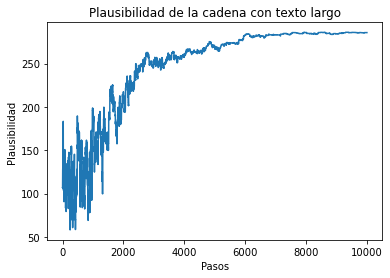

In [38]:
beta = lambda x: 5*10**(-8) * x ** 2
Niter = 10000
beta2, scores2 = SADecipher(ciphertext, Niter, beta, print_period = 1000)
graph_scores(scores2, Niter, "Plausibilidad de la cadena con texto largo")

## Ataque de trigrama